In [155]:
%%capture
!pip install catboost
!pip install category_encoders

In [156]:
#importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

In [157]:
#loading in both the train, test and sample submission files
df_train = pd.read_csv("/content/drive/MyDrive/free-ai-classes-in-every-city-hackathon-2023/Housing_dataset_train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/free-ai-classes-in-every-city-hackathon-2023/Housing_dataset_test.csv")
sample_submission = pd.read_csv("/content/drive/MyDrive/free-ai-classes-in-every-city-hackathon-2023/Sample_submission.csv")

In [158]:
df_train.head()

,ID,loc,title,bedroom,bathroom,parking_space,price
0,3583,Katsina,Semi-detached duplex,2.0,2.0,1.0,1149999.565
1,2748,Ondo,Apartment,NaN,2.0,4.0,1672416.689
2,9261,Ekiti,NaN,7.0,5.0,NaN,3364799.814
3,2224,Anambra,Detached duplex,5.0,2.0,4.0,2410306.756
4,10300,Kogi,Terrace duplex,NaN,5.0,6.0,2600700.898


In [159]:
df_test.head()

,ID,loc,title,bedroom,bathroom,parking_space
0,845,Kano,Penthouse,4,1,2
1,1924,Adamawa,Apartment,2,2,4
2,10718,Adamawa,Bungalow,2,7,2
3,12076,Lagos,Mansion,9,5,2
4,12254,Gombe,Semi-detached duplex,5,6,1


In [160]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             14000 non-null  int64  
 1   loc            12187 non-null  object 
 2   title          12278 non-null  object 
 3   bedroom        12201 non-null  float64
 4   bathroom       12195 non-null  float64
 5   parking_space  12189 non-null  float64
 6   price          14000 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 765.8+ KB


In [161]:

df_train.describe(include="all")

,ID,loc,title,bedroom,bathroom,parking_space,price
count,14000.000000,12187,12278,12201.000000,12195.000000,12189.000000,1.400000e+04
unique,NaN,36,10,NaN,NaN,NaN,NaN
top,NaN,Kaduna,Flat,NaN,NaN,NaN,NaN
freq,NaN,370,1372,NaN,NaN,NaN,NaN
mean,4862.700357,NaN,NaN,4.308171,3.134235,3.169825,2.138082e+06
std,3818.348214,NaN,NaN,2.441165,2.035950,1.599415,1.083057e+06
min,0.000000,NaN,NaN,1.000000,1.000000,1.000000,4.319673e+05
25%,1672.750000,NaN,NaN,2.000000,1.000000,2.000000,1.393990e+06
50%,3527.000000,NaN,NaN,4.000000,2.000000,3.000000,1.895223e+06
75%,8011.250000,NaN,NaN,6.000000,5.000000,4.000000,2.586699e+06


In [162]:
df_train["parking_space"].value_counts()

4.0    2419
2.0    2394
3.0    2378
1.0    2324
6.0    1345
5.0    1329
Name: parking_space, dtype: int64

In [163]:
#dropping the ID column which is not needed
df_train = df_train.drop("ID", axis=1)
df_test = df_test.drop("ID", axis=1)

In [164]:
df_train.isna().sum()

loc              1813
title            1722
bedroom          1799
bathroom         1805
parking_space    1811
price               0
dtype: int64

In [165]:
df_test.isna().sum()

loc              0
title            0
bedroom          0
bathroom         0
parking_space    0
dtype: int64

In [166]:
df_train.dropna(axis=0, inplace=True)

In [167]:
df_train.shape

(5689, 6)

<Axes: xlabel='count', ylabel='title'>

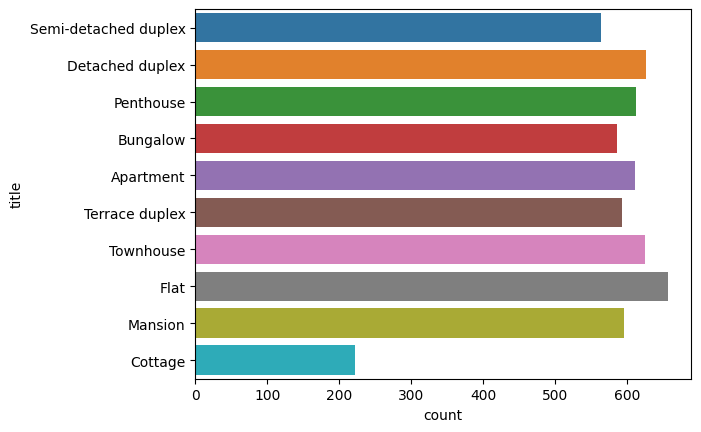

In [168]:
sns.countplot(y=df_train["title"], data=df_train)

<Axes: ylabel='parking_space'>

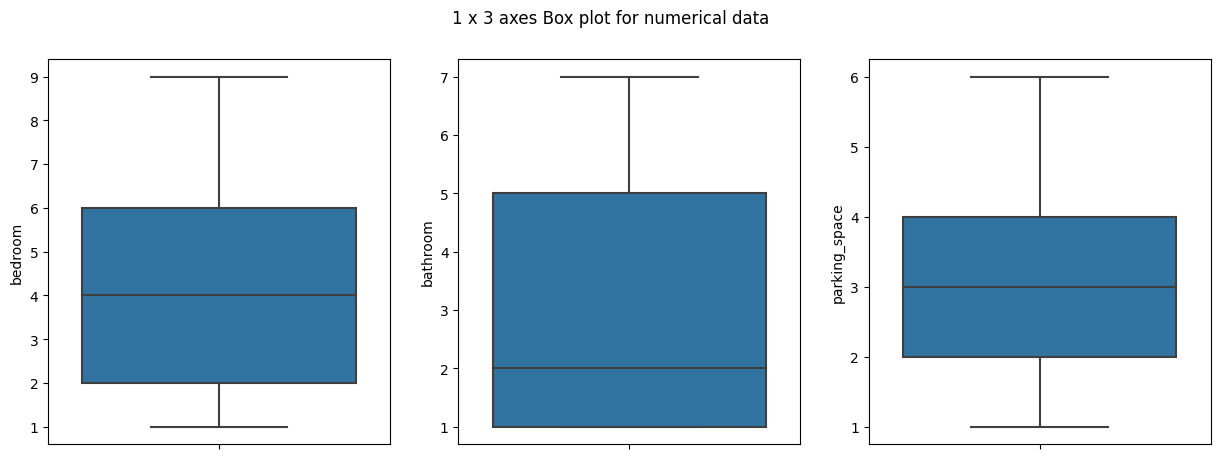

In [169]:
#checking the distribution of the numerical columns using a barplot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('1 x 3 axes Box plot for numerical data')

sns.boxplot(ax=axes[0], y=df_train["bedroom"])
sns.boxplot(ax=axes[1], y=df_train["bathroom"])
sns.boxplot(ax=axes[2], y=df_train["parking_space"])

<Axes: xlabel='parking_space', ylabel='price'>

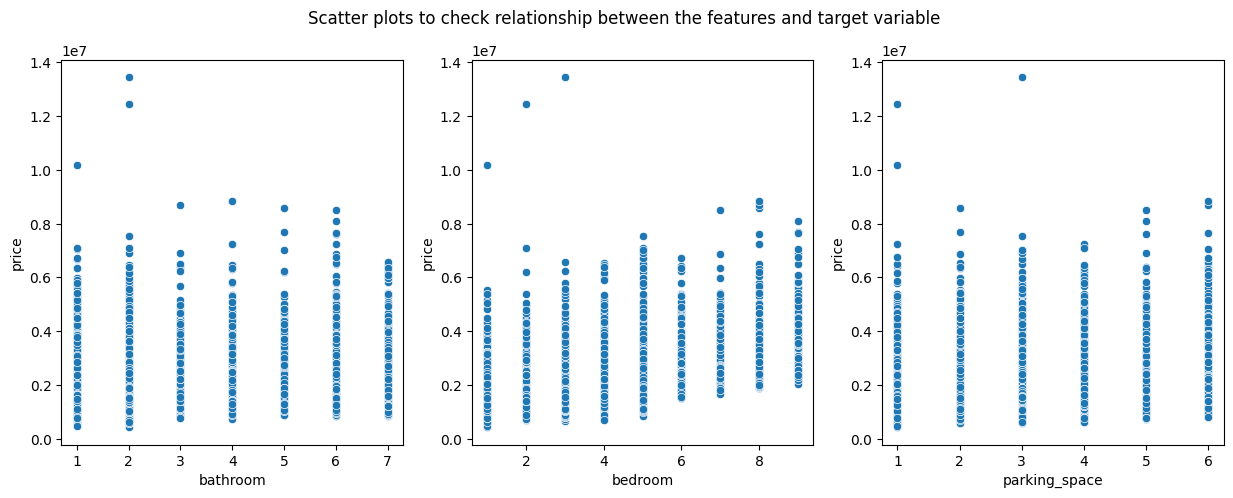

In [170]:
#checking the relationship between some features and the price
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Scatter plots to check relationship between the features and target variable')

sns.scatterplot(ax=axes[0], x="bathroom", y="price", data=df_train)
sns.scatterplot(ax=axes[1], x="bedroom", y="price", data=df_train)
sns.scatterplot(ax=axes[2], x="parking_space", y="price", data=df_train)

<Axes: xlabel='price', ylabel='title'>

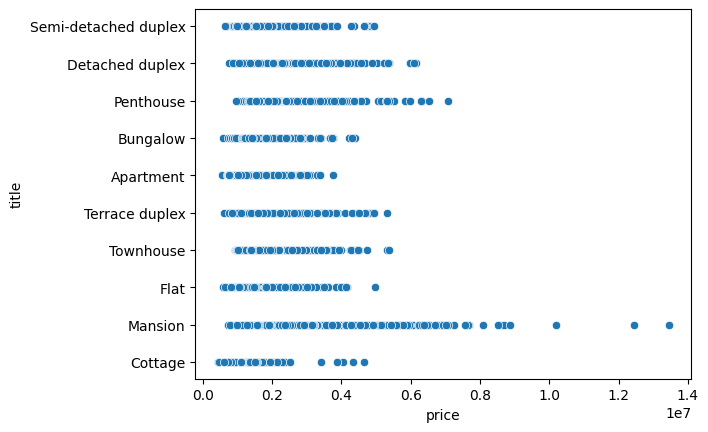

In [171]:
#title vs price
sns.scatterplot(x="price",
                    y="title",
                    data=df_train)

In [172]:
#detecting outliers
column = "price"

upper_limit = df_train[column].mean() + 3* df_train[column].std() # Right from the mean
lower_limit = df_train[column].mean() - 3* df_train[column].std() # Left from the mean

print(upper_limit)
print(lower_limit)

5308429.958317021
-1036285.8585971049


In [173]:
outliers = df_train.loc[df_train[column] >= upper_limit]
outliers["title"].value_counts()

Mansion            74
Penthouse          10
Detached duplex     7
Townhouse           2
Terrace duplex      1
Name: title, dtype: int64

In [174]:
outliers.head()

,loc,title,bedroom,bathroom,parking_space,price
90,Rivers,Mansion,3.0,1.0,4.0,5790058.642
214,Lagos,Penthouse,8.0,7.0,2.0,6336262.513
229,Lagos,Mansion,8.0,5.0,2.0,8593197.387
286,Delta,Mansion,3.0,1.0,2.0,5346209.453
381,Oyo,Mansion,9.0,1.0,6.0,5618725.557


In [175]:
#dropping the outliers
df_train = df_train.drop(df_train[df_train[column] >= upper_limit].index, axis=0)

In [176]:
df_train.shape

(5595, 6)

In [177]:
# Target Encoding
from category_encoders import TargetEncoder
cols = ["loc", "title"]
def target_encode(cols, train_data, test_data=None):
    for col in cols:
        target_enc = TargetEncoder()
        train_data[col] = target_enc.fit_transform(train_data[col], train_data["price"])
        if test_data is not None:
            test_data[col] = target_enc.transform(test_data[col])
target_encode(cols, df_train, df_test)

In [178]:
#creating new columns
df_train["Total"] = df_train["bedroom"] + df_train["bathroom"] + df_train["parking_space"]
df_test["Total"] = df_test["bedroom"] + df_test["bathroom"] + df_test["parking_space"]

df_train["bedroom_to_bathroom"] = df_train["bedroom"] / df_train["bathroom"]
df_test["bedroom_to_bathroom"] = df_test["bedroom"] / df_test["bathroom"]

df_train["bedroom_to_parking_space"] = df_train["bedroom"] / df_train["parking_space"]
df_test["bedroom_to_parking_space"] = df_test["bedroom"] / df_test["parking_space"]

df_train["bathroom_to_bedroom"] = df_train["bathroom"] / df_train["bedroom"]
df_test["bathroom_to_bedroom"] = df_test["bathroom"] / df_test["bedroom"]

In [179]:
df_train.head()

,loc,title,bedroom,bathroom,parking_space,price,Total,bedroom_to_bathroom,bedroom_to_parking_space,bathroom_to_bedroom
0,1.935725e+06,1.915495e+06,2.0,2.0,1.0,1149999.565,5.0,1.00,2.000000,1.000000
3,2.280285e+06,2.207731e+06,5.0,2.0,4.0,2410306.756,11.0,2.50,1.250000,0.400000
7,1.935725e+06,2.550839e+06,3.0,3.0,5.0,2043107.592,11.0,1.00,0.600000,1.000000
10,2.426449e+06,1.746312e+06,1.0,2.0,6.0,1330213.036,9.0,0.50,0.166667,2.000000
11,2.929431e+06,1.565477e+06,3.0,4.0,2.0,1891772.069,9.0,0.75,1.500000,1.333333


In [180]:
#splitting the data into independent and dependent variables
x_train = df_train.drop("price", axis=1)
y_train = df_train["price"]

In [181]:
#splitting the data into training and testing split
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [182]:
#training the data on random forest
rf = RandomForestRegressor(random_state=42, n_estimators=200)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=42)

In [183]:
#training the data on gradient boosting
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

In [128]:
#training the data on catboost
cbr = CatBoostRegressor(random_state=0)
cbr.fit(X_train, y_train)

Learning rate set to 0.051882
0:	learn: 855322.0475689	total: 50.1ms	remaining: 50s
1:	learn: 824935.8799609	total: 56.2ms	remaining: 28s
2:	learn: 796051.1896875	total: 59.9ms	remaining: 19.9s
3:	learn: 768178.0068695	total: 61.8ms	remaining: 15.4s
4:	learn: 742042.0400953	total: 63.9ms	remaining: 12.7s
5:	learn: 717112.6069886	total: 73.6ms	remaining: 12.2s
6:	learn: 693516.7767450	total: 77.9ms	remaining: 11.1s
7:	learn: 673046.5196208	total: 81.7ms	remaining: 10.1s
8:	learn: 651733.1581205	total: 85.5ms	remaining: 9.42s
9:	learn: 629758.7759939	total: 89.3ms	remaining: 8.84s
10:	learn: 608384.6267424	total: 93.7ms	remaining: 8.43s
11:	learn: 589101.2709481	total: 96.5ms	remaining: 7.94s
12:	learn: 571460.0416728	total: 100ms	remaining: 7.62s
13:	learn: 554090.2941212	total: 104ms	remaining: 7.31s
14:	learn: 538294.3147205	total: 108ms	remaining: 7.07s
15:	learn: 523462.1986120	total: 112ms	remaining: 6.86s
16:	learn: 509044.8184024	total: 115ms	remaining: 6.66s
17:	learn: 494781.84

In [184]:
#making predictions
y_pred = gbr.predict(X_test)
gbr.score(X_test, y_test)

0.9242270141363711

In [185]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_pred, y_test))

In [186]:
rmse

247589.16250450825

In [187]:
gbr_preds = gbr.predict(df_test)

In [152]:
preds = np.array([gbr_preds, cbr_preds])
avg_preds = np.mean(preds, axis=0)

In [188]:
sample_submission.head()

,ID
0,845
1,1924
2,10718
3,12076
4,12254


In [189]:
sample_submission["price"] = gbr_preds

In [190]:
sample_submission.to_csv("submission8.csv", index=False)